In [1]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
price_per_state = pd.read_csv('price_per_state.csv')
price_per_state.drop('Rank',axis = 1, inplace = True)

In [3]:
income_by_zip = pd.read_excel('Solar Data/MedianZIP-3.xlsx')
income_by_zip.drop(['Mean', 'Pop'],axis = 1, inplace = True)

In [4]:
solar_data = pd.read_csv('Solar Data/project-sunroof-postal_code-09082017.csv')
solar_data.drop(0, inplace = True)
solar_data['region_name'] = solar_data['region_name'].apply(lambda x : int(x))

In [5]:
election_results = pd.read_csv('Solar Data/Election Results.csv', skiprows= 1, skipfooter=7, engine = 'python')
state_outcomes = election_results[['State', 'PVI']]
state_outcomes['results'] = state_outcomes.PVI.apply(lambda x : str(x)[0])
state_outcomes = state_outcomes[['State','results']]

/home/peter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
solar_income = solar_data.merge(income_by_zip, left_on = 'region_name', right_on = 'Zip', how = 'inner')
solar_income_price = solar_income.merge(price_per_state, left_on = 'state_name', right_on = 'State', how = 'inner')

state_outcomes.index = state_outcomes['State']
state_outcomes_dummies = pd.get_dummies(state_outcomes.results)

solar_income_price_vote = solar_income_price.merge(state_outcomes_dummies, left_on = 'state_name', right_index = True, how = 'inner')

/home/peter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
ages = pd.read_csv('Solar Data/Median age by ZIP.csv')
solar_income_price_vote_age = solar_income_price_vote.merge(ages, left_on = 'region_name', right_on = 'ZIP', how = 'inner')

In [120]:
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]

In [124]:
solar_income_price_vote_age_home = solar_income_price_vote_age.merge(homevalue, left_on = 'region_name', right_on = 'RegionName', how = 'inner')

In [126]:
data = solar_income_price_vote_age_home[['Zhvi','Population', 'Median age','number_of_panels_median','yearly_sunlight_kwh_total', 'percent_qualified', 'Median', 'Price (in cents)', 'D','percent_covered']]
data.dropna(inplace = True)

/home/peter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [127]:
data.columns

Index(['Zhvi', 'Population', 'Median age', 'number_of_panels_median',
       'yearly_sunlight_kwh_total', 'percent_qualified', 'Median',
       'Price (in cents)', 'D', 'percent_covered'],
      dtype='object')

In [128]:
data = data.rename(columns = {
             'Zhvi':'Median_Home_Value', 
             'Population':'Population', 
             'Median age':'Median_Age', 
             'number_of_panels_median':'Median_No_Panels',
             'yearly_sunlight_kwh_total':'Yearly_Solar_Kwh_Tot', 
             'percent_qualified': 'Percent_Roofs_Qualified', 
             'Median':'Median_Income',
             'Price (in cents)':'Price_of_Power', 
             'D':'Democract', 
             'percent_covered':'Percent_Covered'})

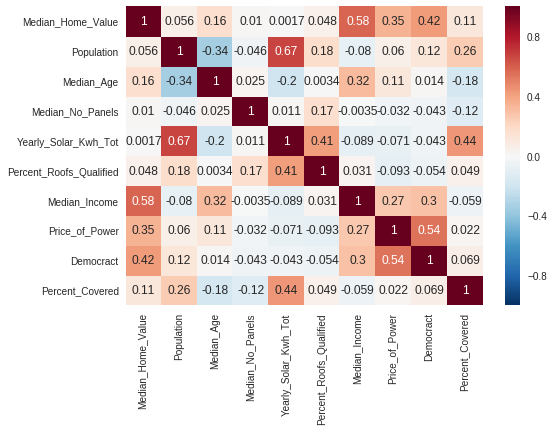

In [129]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot= True)
plt.show()

In [130]:
X = data.drop('Percent_Covered', axis = 1)
Y = data['Percent_Covered']

In [142]:
X_Train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)
rfr = RandomForestRegressor()

rfr.fit(X_Train, Y_train)
Y_ = rfr.predict(X_test)
r2_score(Y_test, Y_)

0.80566519049767882

In [143]:
# headers = ["name", "score"]
# values = sorted(zip(X_Train.columns, rfr.feature_importances_), key=lambda x: x[1] * -1)
# print(tabulate(values, headers, tablefmt="plain"))

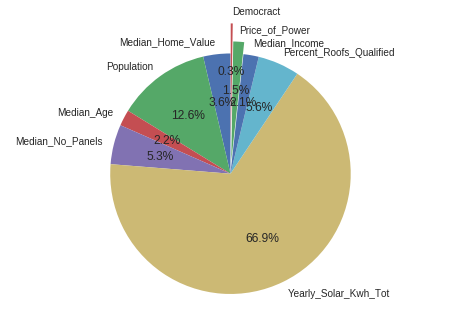

In [145]:

labels = X_Train.columns
sizes = rfr.feature_importances_
explode = (0, 0, 0, 0, 0 ,0 ,0 ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [136]:
score = cross_val_score(rfr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.732303564266
0.0898959332203


array([ 0.68483883,  0.80403287,  0.82667675,  0.76535524,  0.58061412])

In [137]:
gbr = GradientBoostingRegressor()
score = cross_val_score(gbr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.746436479602
0.0554952780522


array([ 0.70282575,  0.7751945 ,  0.8111255 ,  0.78169811,  0.66133854])